# Doc2Vec (Figures 3, 4 and Tables 3, 4)

adapted (partially) from https://github.com/piskvorky/gensim/blob/develop/docs/notebooks/doc2vec-IMDB.ipynb

In [1]:
import json
import re
from collections import namedtuple

import gensim

train = False

Document = namedtuple('Document', 'words tags')

alldocs = []  # will hold all docs in original order
with open('../data/c_twitter.json') as f_in:
    for i, line in enumerate(f_in):
        c_twt = json.loads(line)
        # c_twt: {'weeknum': str, 'c_text': str, 'tags': [str]}
        words = c_twt['text'].split()
        tags = [str(c_twt['id'])] + c_twt['tags']
        alldocs.append(Document(words, tags))
        
shuffle_docs = alldocs[:]
print('number of tweets:', len(alldocs))

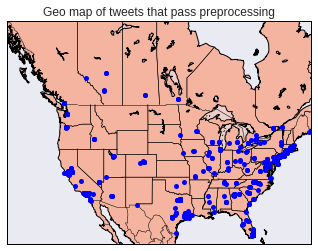

number of geo-tweets: 9370


In [2]:
import sys
if not('/high_spd_work/sm_w2v' in sys.path):
    sys.path.append('/high_spd_work/sm_w2v')
    
from sm_w2v.plot_utils import plot_map_twts
%matplotlib inline

def twt_gen():
    with open('../data/c_twitter.json') as f_in:
        for line in f_in:
            c_twt = json.loads(line)
            if 'coordinates' in c_twt:
                yield c_twt
            
geo_twts = list(twt_gen())
plot_map_twts(geo_twts, 'Geo map of tweets that pass preprocessing')
print('number of geo-tweets:', len(geo_twts))

# Build model and train (or load model from file)

In [3]:
import multiprocessing
from random import shuffle
import random
import time

from gensim.models import Doc2Vec
import gensim.models.doc2vec

import numpy as np

random.seed(1)
np.random.seed(1)



if train:
    cores = multiprocessing.cpu_count()
    assert gensim.models.doc2vec.FAST_VERSION > -1, "this will be painfully slow otherwise"

    # PV-DM w/average
    model= Doc2Vec(dm=1, dm_mean=1, size=100, window=3, negative=5, hs=0, min_count=2, workers=cores,
               max_vocab_size=10000, seed=1)


    # the array is too big
    model.build_vocab(alldocs)
    print("model:", model)

    # train model
    passes = 15
    start_time = time.time()

    for epoch in range(passes):
        shuffle(shuffle_docs)
        model.train(shuffle_docs)
        print(epoch, model.most_similar('hiv', topn=10))

        # do some validation after each epoch
        doc_ids = random.sample(range(len(alldocs)), 1000)
        score = 0
        for doc_id in doc_ids:
            inferred_docvec = model.infer_vector(alldocs[doc_id].words)
            score += sum(abs(model.docvecs[doc_id] - inferred_docvec))
        print("--- score: ", score)
        print("ELAPSED TIME (seconds): ", time.time() - start_time)

    model.save('../models/doc2vec.model')
else:
    model = Doc2Vec.load('../models/doc2vec.model')

model: Doc2Vec(dm/m,d100,n5,w3,mc2,t6)
0 [('hivaids', 0.8431283831596375), ('benegative', 0.7571459412574768), ('sexworkers', 0.7536641955375671), ('humanrights', 0.7314331531524658), ('prep', 0.7189432978630066), ('aids2016', 0.7025149464607239), ('hivtestweek', 0.6972944736480713), ('sexwork', 0.6948752403259277), ('kolastirio', 0.691129207611084), ('gettested', 0.6911174654960632)]
--- score:  14182.2561847
ELAPSED TIME (seconds):  158.77099752426147
1 [('hivaids', 0.879742443561554), ('kolastirio', 0.820827305316925), ('hivtestweek', 0.8092121481895447), ('humanrights', 0.8086100220680237), ('staynegathive', 0.8028442859649658), ('safesex', 0.7945687770843506), ('benegative', 0.7915849089622498), ('stophivstigma', 0.7888946533203125), ('hearingloss', 0.781371533870697), ('endadolescentaids', 0.7792447209358215)]
--- score:  18359.3044682
ELAPSED TIME (seconds):  321.4566788673401
2 [('hivaids', 0.8950912952423096), ('kolastirio', 0.833741307258606), ('hivtestweek', 0.82805114984512

# Table 4: Related Word-Vectors

In [4]:
import pandas as pd
new_vecs = model.most_similar(['hivaids'], topn=10)
df_hivaids = pd.DataFrame(data=new_vecs, columns=['Related-Word', 'Cosine Similarity to \"hivaids\"'])
df_hivaids

,Related-Word,"Cosine Similarity to ""hivaids"""
0,hiv,0.912221
1,aidshiv,0.834456
2,hiv-aids,0.820868
3,communityhealthworkers,0.787574
4,hivtestweek,0.753117
5,rethinkhiv,0.736994
6,hivchat,0.732641
7,raghwanij,0.732297
8,truvada,0.730966
9,aldubhappytogether,0.718584


In [5]:
new_vecs = model.most_similar(['prep'], topn=10)
df_prep = pd.DataFrame(data=new_vecs, columns=['Related Word', 'Cosine Similarity to \"prep\"'])
df_prep

,Related Word,"Cosine Similarity to ""prep"""
0,truvada,0.836507
1,benegative,0.809185
2,charliesheen,0.805214
3,hivtestweek,0.797361
4,sexwork,0.774867
5,gettested,0.765772
6,hiv,0.765389
7,icasa2015,0.749948
8,doingit,0.749230
9,aids,0.738572


In [6]:
new_vecs = model.most_similar(['prophylaxis'], topn=10)
df_prophylaxis = pd.DataFrame(data=new_vecs, columns=['Related Word', 'Cosine Similarity to \"prophylaxis\"'])
df_prophylaxis

,Related Word,"Cosine Similarity to ""prophylaxis"""
0,practice,0.463609
1,adherence,0.462515
2,invest,0.444301
3,treatments,0.438242
4,prison,0.430760
5,reducing,0.427932
6,responses,0.421723
7,trials,0.417625
8,prep,0.410655
9,fight,0.410108


In [7]:
new_vecs = model.most_similar(['truvada'], topn=10)
df_truvada = pd.DataFrame(data=new_vecs, columns=['Related Word', 'Cosine Similarity to \"truvada\"'])
df_truvada

,Related Word,"Cosine Similarity to ""truvada"""
0,prep,0.836507
1,charliesheen,0.774535
2,worldaidsday,0.759242
3,hivtestweek,0.748214
4,hiv,0.744817
5,hivaids,0.730966
6,aidsfreefuture,0.721897
7,icasa2015,0.713624
8,benegative,0.709129
9,martinshkreli,0.702565


# Figure 3: PCA and tSNE plots of relevent word vectors

PCA explained variance ratio:  [ 0.07763831  0.06166739]


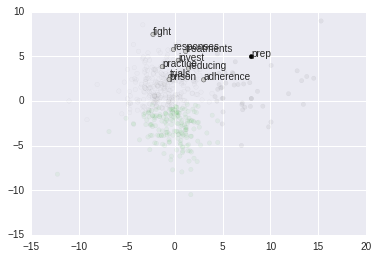

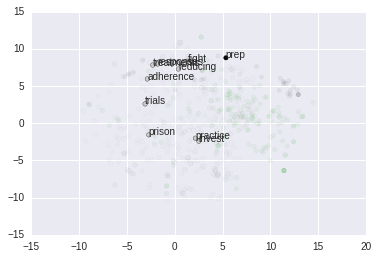

In [8]:
import sys

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

# append path to my module
if '/high_spd_work/sm_w2v' not in sys.path:
    sys.path.append('/high_spd_work/sm_w2v')
from sm_w2v.plot_utils import scatter_plot

# related words from above
related_words = list(df_prophylaxis.iloc[:,0].values)

# Prepare data matrix
X = []
text_annotations = []
for word in model.vocab:
    X.append(model[word])
    if word in related_words:
        text_annotations.append(word)
    else:
        text_annotations.append("")
X = np.array(X)

# Do k-means on original data matrix
kmeans = KMeans(n_clusters=3, random_state=1)
kmeans_labels = kmeans.fit_predict(X)

# Do PCA
pca = PCA(n_components=2, copy=True)
pca.fit(X)
print("PCA explained variance ratio: ", pca.explained_variance_ratio_)
pca_comps = pca.transform(X)

# Do tSNE
tsne = TSNE(n_components=2, random_state=1)
tsne_comps = tsne.fit_transform(X)

# Scatter plot
rand_seed = 0
alpha_high = 1.0
alpha_low = 0.05
down_samp_rate = 0.1

# save PCA plot in 'notebooks' directory
scatter_plot(pca_comps[:,0], pca_comps[:,1], alpha_high, alpha_low,
            kmeans_labels, text_annotations,
            down_samp_rate, "Fig3a: PCA of 'Prophylaxis' Related Words", rand_seed, None)

# save tSNE plot in 'notebooks' directory
scatter_plot(tsne_comps[:,0], tsne_comps[:,1], alpha_high, alpha_low,
            kmeans_labels, text_annotations,
            down_samp_rate, "Fig3b: tSNE of 'Prophylaxis' Related Words", rand_seed, None)

# Table 4: Related Hashtags and Tweets

Hashtags begin with "#", users begin with "user--" and tweets are just a number - that refers to the corresponding index in the "alldocs" variable, or the "../data/c_twitter.json" cleaned tweets file

In [9]:
new_vecs = model.docvecs.most_similar(['#truvada'], topn=10)
df_hash_truvada = pd.DataFrame(data=new_vecs, columns=['Related Hashtag/User/Tweet', 'Cosine Similarity to \"#truvada\"'])
df_hash_truvada

,Related Hashtag/User/Tweet,"Cosine Similarity to ""#truvada"""
0,#prep,0.740855
1,#hiv,0.646245
2,685501883448963072,0.582529
3,#prevention,0.578786
4,#potus,0.561461
5,688733331081527296,0.558048
6,#メル友,0.557464
7,#セフレ,0.556990
8,#bbbh,0.547450
9,#cure,0.545497


In [17]:
# new_vecs = model.docvecs.most_similar(['#sexwork'], topn=10)
# df_hash_sexwork = pd.DataFrame(data=new_vecs, columns=['Related Hashtag/User/Tweet', 'Cosine Similarity to \"#sexwork\"'])
# df_hash_sexwork

In [11]:
new_vecs = model.docvecs.most_similar(['#prep'], topn=10)
df_hash_prep = pd.DataFrame(data=new_vecs, columns=['Related Related Hashtag/User/Tweet', 'Cosine Similarity to \"#prep\"'])
df_hash_prep

,Related Related Hashtag/User/Tweet,"Cosine Similarity to ""#prep"""
0,#truvada,0.740855
1,#hiv,0.725051
2,#prevention,0.641610
3,#メル友,0.637352
4,#セフレ,0.637108
5,685501883448963072,0.621571
6,#gay,0.615640
7,#sex,0.612466
8,#prepworks,0.606486
9,686143301938987008,0.605270


In [12]:
# note, this tweet is popular, warning about 13 signs which indicate that you need HIV testing.
# We see evidence of this populat tweet-retweet in both DTM and Doc2Vec:
#
# Document(words=['#', 'krtebireysyle', 'if', 'you', 'see', 'this', '13',
# 'symptoms', '.', 'do', 'hiv', 'test', 'immediately', '.', 'please', 'read'],
# tags=[603177, '#KFB_Mz_Sope', 'kürtçebirşeysöyle'])
#
[doc for doc in alldocs if int(doc.tags[0]) == 689027472776630274]

[Document(words=['#', 'bluemonday', 'if', 'you', 'see', 'this', '13', 'symptoms', '.', 'do', 'hiv', 'test', 'immediately', '.', 'please', 'read'], tags=['689027472776630274', '♔KINDLY FOLLOW BACK♔-*-4171549167', '#bluemonday'])]

In [13]:
new_vecs = model.docvecs.most_similar(['#imtesting'], topn=10)
df_hash_imtesting = pd.DataFrame(data=new_vecs, columns=['Related Related Hashtag/User/Tweet', 'Cosine Similarity to \"#imtesting\"'])
df_hash_imtesting

,Related Related Hashtag/User/Tweet,"Cosine Similarity to ""#imtesting"""
0,#hivtestweek,0.615264
1,#wadirl,0.571929
2,#gettested,0.532500
3,Positively Different-*-3652471395,0.492830
4,#eurohivheptestweek,0.484347
5,David Rowlands-*-2416339741,0.481121
6,#wad2015,0.480624
7,#beachmobile,0.444205
8,#endinghiv,0.440666
9,yorkshire mesmac-*-74150233,0.440663


# Figure 4: Related Hashtags and Tweets

PCA explained variance ratio:  [ 0.0688083   0.03959215]


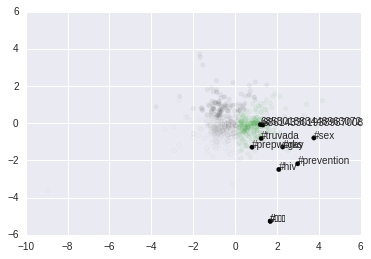

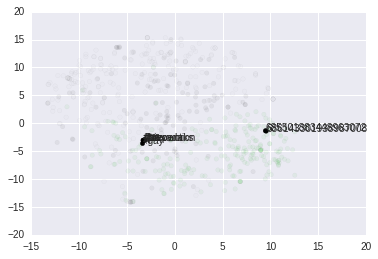

In [14]:
# related words from above
related_words = list(df_hash_prep.iloc[:,0].values)


# Prepare data matrix
X = []
text_annotations = []
for i, word in enumerate(model.docvecs.doctags):
    if (i % 100 == 0 or word in related_words) :
        X.append(model.docvecs[word])
        if word in related_words:
            text_annotations.append(word)
        else:
            text_annotations.append("")
X = np.array(X)

# Do k-means on original data matrix
kmeans = KMeans(n_clusters=3, random_state=1)
kmeans_labels = kmeans.fit_predict(X)

# Do PCA
pca = PCA(n_components=2, copy=True)
pca.fit(X)
print("PCA explained variance ratio: ", pca.explained_variance_ratio_)
pca_comps = pca.transform(X)

# Do tSNE
tsne = TSNE(n_components=2, random_state=1)
tsne_comps = tsne.fit_transform(X)

# Scatter plot
rand_seed = 0
alpha_high = 1.0
alpha_low = 0.05
down_samp_rate = 0.1

# save PCA plot in 'notebooks' directory (it won't show here in the notebook)
scatter_plot(pca_comps[:,0], pca_comps[:,1], alpha_high, alpha_low,
            kmeans_labels, text_annotations,
            down_samp_rate, "Fig4a: PCA of Related Hashtags-Users-Tweets to '#prep'", rand_seed, None)

# save tSNE plot in 'notebooks' directory (it won't show here in the notebook)
scatter_plot(tsne_comps[:,0], tsne_comps[:,1], alpha_high, alpha_low,
            kmeans_labels, text_annotations,
            down_samp_rate, "Fig4b: tSNE of Hashtags-Users-Tweets to '#prep'", rand_seed, None)

# get ~24,000 users related to PrEP sorted

and store in '../data/top_users_to_PrEP.txt'


this is providing data for other notebook:

`topic_modeling_on_user-timelines.ipynb`

and was only run once:



In [15]:
# # get top 1000 user id strings and save for user-timeline analysis
# sim_vecs = model.docvecs.most_similar(['#prep'], topn=100000)
# users = []
# for v in sim_vecs:
#     l = v[0].split('-*-')
#     if len(l) > 1:
#         users.append(l[-1])

# with open('../data/top_users_to_PrEP.txt', 'w') as f_out:
#     f_out.write('\n'.join(users))
